In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
theano.config.floatX = 'float32'
theano.config.openmp = True

from matplotlib import pyplot as plt
%matplotlib inline



Couldn't import dot_parser, loading of dot files will not be possible.


# configure network
* the network architecture can be read from the architecture tab
 * just one-way successive dense layers, intertwining with dropout layers
   * a dropout layer zeroes-out random neurons each run to avoid overfitting
 * one additional dropout layer is added at the very beginning (right after input)
  
* no proper experiments were done with convolutional layers (CNN)
 * and none will be until we get our GPUs
 * otherwise it takes months to fully train such NN
 
* the network is built using mainly Lasagne and Theano
 * Theano is a mathematical framework for fast resourse-optimized computation
   * A theano algorithm is essentially a computational graph that is automatically optimized and compiled for the available hardware (single-CPU,multi-CPU,GPU, multi-GPU)
   * https://github.com/Theano/Theano
 * Lasagne is a low-level neural network framework, compatible with Theano
   * http://lasagne.readthedocs.org/en/latest/index.html

In [23]:
input_shape = [None,3,32,32]
output_shape = [None,3,1,50]
_input_image_pair = T.tensor4('image_pair',dtype='floatX')
_target = T.tensor4('decay_prediction',dtype='floatX')

## network body

In [3]:
#architecture
_nn = lasagne.layers.InputLayer(shape = input_shape,name='input_images',
                                input_var=_input_image_pair)

_nn = lasagne.layers.DropoutLayer(_nn,name="drop_inputs",p=0.2)

_nn = lasagne.layers.DenseLayer(_nn,name="dense0",
                                num_units = 128,
                                nonlinearity=lasagne.nonlinearities.sigmoid)

#_nn = lasagne.layers.DropoutLayer(_nn,name="drop_from_dense0",p=0.5)

_nn = lasagne.layers.DenseLayer(_nn,num_units = 128,name="dense1",
                             nonlinearity=lasagne.nonlinearities.sigmoid)

#_nn = lasagne.layers.DropoutLayer(_nn,name="drop_from_dense1",p=0.25)



n_outputs_per_dim = 50
_dense_outputs_list = [
    lasagne.layers.DenseLayer(_nn, name = 'dense_output.'+dim_name,
                                 num_units=n_outputs_per_dim,
                                 W=lasagne.init.GlorotUniform(),                     
                                 nonlinearity=lasagne.nonlinearities.softmax)
    for dim_name in 'xyz'
]



_nn = lasagne.layers.ConcatLayer(_dense_outputs_list)

_nn = lasagne.layers.ReshapeLayer(_nn,shape = [-1]+output_shape[1:])

In [4]:
# network output function WITH random dropout
#raw shape: [ None,prod(output_shape) ]

_prediction = lasagne.layers.get_output(_nn,inputs=_input_image_pair)


## optimization objectives

In [25]:
# obtaining optimizable network parameters
_nn_weights = lasagne.layers.get_all_params(_nn,trainable=True)
print _nn_weights

[dense0.W, dense0.b, dense1.W, dense1.b, dense_output.x.W, dense_output.x.b, dense_output.y.W, dense_output.y.b, dense_output.z.W, dense_output.z.b]


In [62]:
#constants for tweaking


_shared = lambda name,val: theano.shared(np.float32(val),name,strict = True)

_entropy_weight =_shared("entropy_weight",1)
_l2_weight = _shared("l2_weight",0)


In [9]:
# constructing objective function

# crossentropy

_crossentropy = lasagne.objectives.categorical_crossentropy(_prediction,_target).mean()



# cosine similarity with normalization applied to prediction only (since target Y is constant)
from retina.compiled import normalize
_prediction_normalized = normalize(_prediction).reshape([-1]+list(output_shape[1:]))
_cosine_similarity = (_prediction_normalized*_target).sum()


#prediction entropy
_prediction_entropy = lasagne.objectives.categorical_crossentropy(_prediction,_prediction).mean()



# L2 (Tikhonov) regularizer
_reg_l2 = lasagne.regularization.regularize_network_params(_nn,
                            penalty = lasagne.regularization.l2)

# combined objective function
_unregularized_loss = _crossentropy 
_loss = _unregularized_loss + _reg_l2*0.00001 + _prediction_entropy*5

In [10]:
# optimization algorithm
_nn_update = lasagne.updates.nesterov_momentum(_loss,
                                               params = _nn_weights,
                                               learning_rate = .01
                                              )

In [11]:
# compiled optimization algorithm
train_fun = theano.function([_input_image_pair,_target],
                            _loss,
                            updates=_nn_update,
                           #mode=theano.compile.mode.FAST_COMPILE
                           )

In [13]:
# network output function WITHOUT dropout 
# dropout gets replaced with reweighting all outputs by (1 - P(drop) )
# thus, the output becomes DETERMINISTIC and uses whole network
_det_prediction = lasagne.layers.get_output(_nn,inputs=_input_image_pair,deterministic=True)

# compiled deterministic output function (for evaluation and prediction)
predict = theano.function([_input_image_pair],_det_prediction)

# fetch data
* load several retina images, concatenate them into pairs
 * a pair consists of two retina images of the SAME event
 * the difference is the position and orientation of the retina grid
* the retina images are 32x32 pixels each

In [14]:
img_folder = "/mnt/KSfinder/"
import os
X = np.load(os.path.join(img_folder,"ksfinder_images.npy"))
y = np.load(os.path.join(img_folder,"ksfinder_targets.npy"))
print X.shape,y.shape

(27185, 3, 32, 32) (27185, 3, 50)


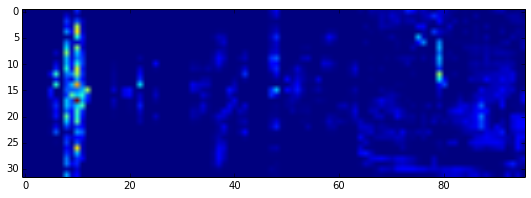

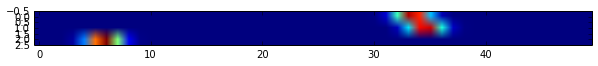

In [15]:
i = 0
plt.figure(figsize=[10,3])
plt.imshow(np.hstack(X[i]))
plt.show()
plt.figure(figsize=[10,3])
plt.imshow(np.vstack(y[i]))
plt.show()

In [16]:
#setup data format
X= X.reshape(-1,*input_shape[1:]).astype('float32')
y = y.reshape(-1,*output_shape[1:]).astype('float32')
print X.shape,y.shape

(27185, 3, 32, 32) (27185, 3, 1, 50)


In [17]:
from sklearn.cross_validation import train_test_split
Xtr,Xts,Ytr,Yts = train_test_split(X,y,test_size=0.3,random_state=42)

# train it
* by iteratively picking minibatches and training on them
* the method used for iterations is
 * Stochastic Gradient Descent (SGD) updates with Nesterov momentum
 * used it just because i heard it's good, no actual analysis done
* Uniform additive l2 regularization is applied to the network to prevent overfitting as well
 * regularization constant was briefly tweaked via crossvalidation for ROC AUC
 * more sophisticated regularizers were not analyzed

In [18]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [19]:
from sklearn.metrics import roc_auc_score,accuracy_score

score_fun = theano.function([_input_image_pair,_target],
                            _unregularized_loss,
                           #mode=theano.compile.mode.FAST_COMPILE
                           )
entropy_fun = theano.function([_input_image_pair,_target],
                            _prediction_entropy,
                            on_unused_input='ignore',
                           #mode=theano.compile.mode.FAST_COMPILE
                           )


def evaluate(X,y_targ):
    score = score_fun(X,y_targ)
    entropy = entropy_fun(X,y_targ)
    
    print 'loss:',score
    print 'entropy:',entropy
    
    
    return score
    

In [20]:
import random
def show_sample_predictions(X,y,count=10):
    y_pred = predict(X)
    
    y/=np.linalg.norm(y,axis=-1,keepdims=True)
    
    for n in range(count):
        i = random.randint(0,len(y) -1)

        plt.figure(figsize=[15,2])
        plt.imshow(y[i].reshape(-1,50),interpolation='none')
        plt.title('sample %i reference'%i)
        plt.colorbar()
        plt.show()

        plt.figure(figsize=[15,2])
        plt.imshow(y_pred[i].reshape(-1,50),interpolation='none')
        plt.title('sample %i prediction'%i)
        plt.colorbar()
        plt.show()

In [21]:
#global epoch counter (useful if several train loops were started in succession)
epochCounter = 0
train_scores = {}
test_scores = {}

train loss:  38.7516
-------------------------
epoch 0/500, 0 total

layer RMS:
	dense0.W : 0.0250460496276
	dense0.b : 0.00132266819118
	dense1.W : 0.0884609684454
	dense1.b : 0.00879138180808
	dense_output.x.W : 0.107467892934
	dense_output.x.b : 0.0379149882776
	dense_output.y.W : 0.107779717472
	dense_output.y.b : 0.0379965739405
	dense_output.z.W : 0.107061027123
	dense_output.z.b : 0.0308001444768

train score:
loss: 30.1484737396
entropy: 1.38221776485

test score:
loss: 29.5992660522
entropy: 1.38199806213



/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


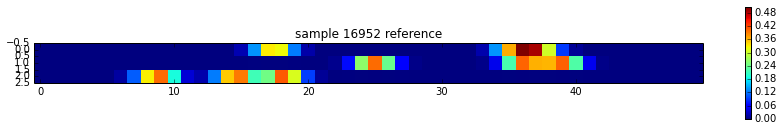

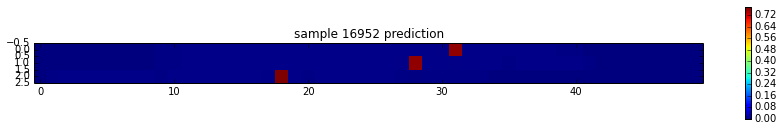

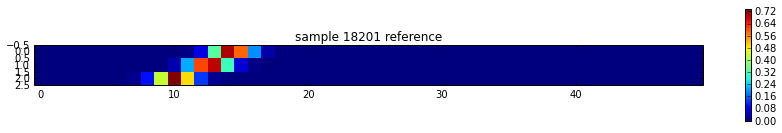

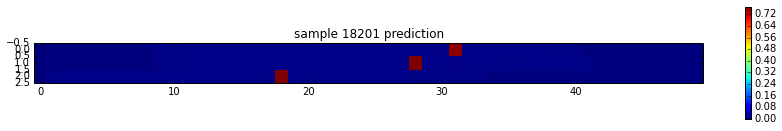

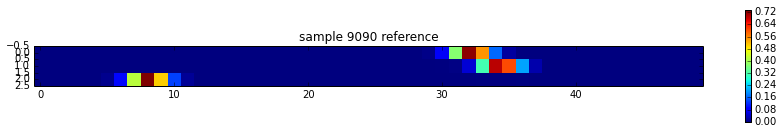

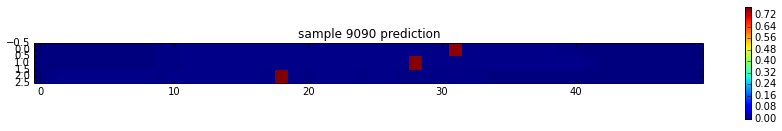

train loss:  18.6971
train loss:  18.6292
train loss:  18.6274
train loss:  18.6238
train loss:  18.6241
-------------------------
epoch 5/500, 5 total

layer RMS:
	dense0.W : 0.0250452001818
	dense0.b : 0.00191965046059
	dense1.W : 0.0885117465076
	dense1.b : 0.010760148027
	dense_output.x.W : 0.108379156099
	dense_output.x.b : 0.0451914870119
	dense_output.y.W : 0.108549952937
	dense_output.y.b : 0.0444108019004
	dense_output.z.W : 0.107170382793
	dense_output.z.b : 0.0323647494924

train score:
loss: 15.6064720154
entropy: 0.601702988148

test score:
loss: 35.3051795959
entropy: 0.60165554285



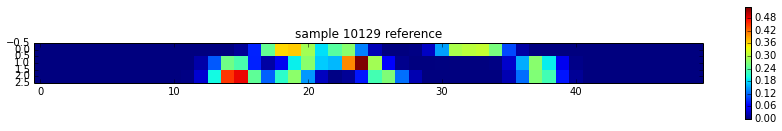

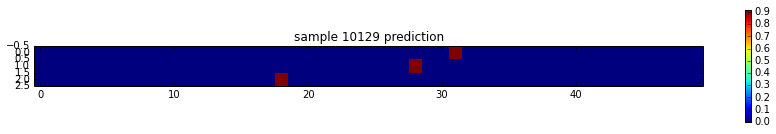

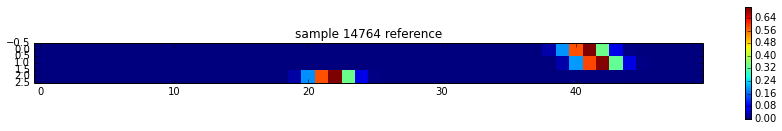

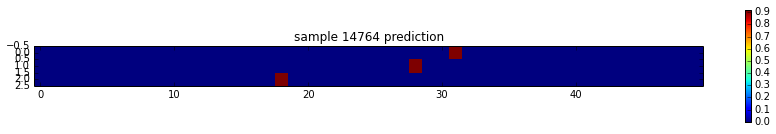

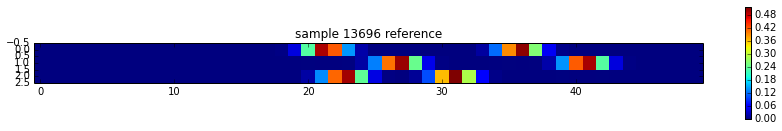

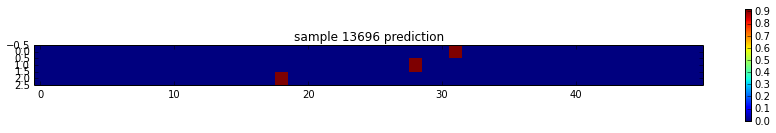

KeyboardInterrupt: 

In [22]:
n_epochs= 500
batch_size = 500
for i in range(n_epochs):
    err=[]
    for (batch_X,batch_y) in iterate_minibatches(Xtr,Ytr,batch_size,shuffle=True):
        err.append(train_fun(batch_X,batch_y))
    
    
    print 'train loss: ',np.mean(err)
    if epochCounter%5==0:
        print '-'*25
        print 'epoch {}/{}, {} total'.format(i,n_epochs,epochCounter)
        print
        
        print "layer RMS:"
        for param in _nn_weights:
            RMS_weights = (param.get_value()**2).mean()**.5
            print '\t',param,':',RMS_weights
        print
        
        
        
        print 'train score:'
        train_scores[epochCounter] = evaluate(Xtr,Ytr)
        print
        
        
        print 'test score:'
        test_scores[epochCounter] = evaluate(Xts,Yts)
        print
        #print '.'*25
        show_sample_predictions(Xtr,Ytr,count=3)
    
    epochCounter+=1



In [ ]:
keys,values = zip(*train_scores.items())
values = np.hstack(values)
plt.plot(keys,values,label="train")
keys,values = zip(*test_scores.items())
values = np.hstack(values)
plt.plot(keys,values,label="test")

#plt.xlim()

In [ ]:
keys,values = zip(*train_scores.items())
values = np.hstack(values)
plt.plot(keys,values,label="train")
keys,values = zip(*test_scores.items())
values = np.hstack(values)
plt.plot(keys,values,label="test")

plt.xlim(0,10000)

In [ ]:
show_sample_predictions(Xtr,Ytr)

In [ ]:
i = 0
y[i].shape

# Final evaluation

In [ ]:
print "Final scores on the training set:"
evaluate(Xtr,Ytr)

print "Final scores on the test set:"
evaluate(Xts,Yts)


# brief conclusion
TODO

In [ ]:
# here the notebook ends

In [ ]:
ww = _nn_weights[0].get_value().T.reshape(-1,64,32)

In [ ]:
from random import choice
i = choice(range(100))
plt.figure(figsize=[7,14])
plt.imshow(ww[i],cmap='bone')
plt.colorbar()
print i
